In [18]:
# Import libraries

import pandas as pd
import spotipy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [20]:
# Load data
takeaway_1 = pd.read_csv("restaurant-1-orders.csv")
takeaway_1.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [21]:
# Lets get the number of unique orders, we can do this by creating a set from the 'Order Number'

total_orders = set(takeaway_1['Order Number'])
len(total_orders)

13397

In [90]:
# We have our data loaded for our first restaurant, lets have a look at what the most popular menu item is.
# We can do this by creating a dictionary and adding the quantity as the counts, at the same time we will calculate
# monthly spend and total spend

monthly_spend = {}
total_items = {}
total_value = 0

for row in takeaway_1.itertuples():
    # Orders for each item
    if row[3] in total_items:
        total_items[row[3]] = total_items[row[3]] + row[4]
    else:
        total_items[row[3]] = row[4]
    # Monthly sales
    month_year = datetime.strftime(datetime.strptime(row[2], '%d/%m/%Y %H:%M').date(),'%m/%Y')
    if month_year in monthly_spend:
        monthly_spend[month_year] += row[4] * row[5]
    else:
        monthly_spend[month_year] = row[4] * row[5]
    
    total_value += row[4] * row[5]

total_items = {k:v for k,v in sorted(total_items.items(), key = lambda item:item[1], reverse=True)}
monthly_spend = {k:v for k,v in sorted(monthly_spend.items(), key = lambda item:datetime.strptime(item[0], '%m/%Y'))}
total_items

{'Plain Papadum': 10648,
 'Pilau Rice': 6367,
 'Plain Naan': 4983,
 'Garlic Naan': 3318,
 'Plain Rice': 2964,
 'Onion Bhajee': 2749,
 'Mango Chutney': 2504,
 'Chicken Tikka Masala': 2473,
 'Chapati': 1935,
 'Mint Sauce': 1840,
 'Bombay Aloo': 1831,
 'Peshwari Naan': 1734,
 'Mushroom Rice': 1615,
 'Keema Naan': 1520,
 'Meat Samosa': 1411,
 'Korma': 1370,
 'Onion Chutney': 1291,
 'Saag Aloo': 1234,
 'Korma - Chicken': 1091,
 'Butter Chicken': 1068,
 'Chicken Tikka (Main)': 905,
 'Madras': 851,
 'Spicy Papadum': 784,
 'Chicken Biryani': 771,
 'Red Sauce': 728,
 'Chicken Tikka': 728,
 'Tandoori Mixed Grill': 716,
 'Special Fried Rice': 713,
 'Curry': 639,
 'Aloo Gobi': 620,
 'Lamb Biryani': 602,
 'Tandoori Roti': 593,
 'Sheek Kebab': 589,
 'Mixed Starter': 586,
 'Tarka Dall': 567,
 'French Fries': 560,
 'Saag Paneer': 537,
 'Bhuna': 524,
 'Madras - Chicken': 508,
 'Chicken Tikka Biryani': 500,
 'Chicken Tikka Jalfrezi': 481,
 'Paratha': 474,
 'Vegetable Rice': 459,
 'Curry - Chicken': 457,

In [91]:
# I definitely prefer naan personally, but each to their own! Chicken Tikka Masala looks like the most popular curry,
# British classic!

monthly_spend = list(map(lambda x: int(monthly_spend[x]),monthly_spend))
monthly_spend

[189,
 223,
 3511,
 5520,
 6121,
 3575,
 2810,
 6560,
 7175,
 9787,
 8928,
 9987,
 9606,
 7793,
 8518,
 10669,
 8890,
 10106,
 11503,
 10179,
 12804,
 11210,
 10382,
 14819,
 11491,
 9132,
 12015,
 9611,
 11468,
 12295,
 12002,
 12582,
 14428,
 13405,
 15029,
 16631,
 12876,
 13578,
 16480,
 14133,
 17099,
 14259,
 15473,
 1644]

In [23]:
# I wonder what the average spend is per order?
avg_spend = round(total_value/len(total_orders),2)
avg_spend

33.33

In [24]:
# Can we find out the most popular times of ordering? To do this need to separate the order dates into buckets
# We slice the dataframe to just order number and order date for easier manipulation, then find unique order numbers
# to get unique order dates

unique_order_dates = takeaway_1[["Order Number", "Order Date"]].drop_duplicates(subset=['Order Number'],ignore_index=True)
unique_order_dates.head()

,Order Number,Order Date
0,16118,03/08/2019 20:25
1,16117,03/08/2019 20:17
2,16116,03/08/2019 20:09
3,16115,03/08/2019 20:01
4,16114,03/08/2019 19:44


In [25]:
# We can use the weekday and hour to separate the order time into intervals, 000 - represents an order on Monday
# between 00:00 - 00:59, 520 - represents an order on Saturday between 20:00 and 20:59

order_timings = {}
for order in unique_order_dates.itertuples():
    order_date = datetime.strptime(order[2], '%d/%m/%Y %H:%M')
    order_date_interval = f"{order_date.weekday()}{order_date.strftime('%H')}"
    if order_date_interval in order_timings:
        order_timings[order_date_interval] += 1
    else:
        order_timings[order_date_interval] = 1

In [26]:
# Not every time of day has orders placed, but its probably beneficial to include these to get every hour plotted
week = [*range(7)]
hour_slots = [str(x).zfill(2) for x in [*range(24)]]

for day in week:
    for hour in hour_slots:
        if f"{day}{hour}" not in order_timings:
            order_timings[f"{day}{hour}"] = 0
            
order_timings = {k:v for k,v in sorted(order_timings.items(), key = lambda item:item[0])}
order_timings

{'000': 2,
 '001': 3,
 '002': 2,
 '003': 0,
 '004': 1,
 '005': 0,
 '006': 0,
 '007': 0,
 '008': 0,
 '009': 0,
 '010': 3,
 '011': 10,
 '012': 33,
 '013': 25,
 '014': 6,
 '015': 8,
 '016': 34,
 '017': 187,
 '018': 334,
 '019': 280,
 '020': 153,
 '021': 75,
 '022': 34,
 '023': 0,
 '100': 0,
 '101': 0,
 '102': 2,
 '103': 0,
 '104': 1,
 '105': 0,
 '106': 0,
 '107': 0,
 '108': 0,
 '109': 2,
 '110': 3,
 '111': 14,
 '112': 43,
 '113': 13,
 '114': 13,
 '115': 14,
 '116': 28,
 '117': 169,
 '118': 315,
 '119': 311,
 '120': 185,
 '121': 72,
 '122': 41,
 '123': 1,
 '200': 0,
 '201': 0,
 '202': 0,
 '203': 0,
 '204': 0,
 '205': 2,
 '206': 0,
 '207': 0,
 '208': 0,
 '209': 3,
 '210': 1,
 '211': 13,
 '212': 23,
 '213': 27,
 '214': 11,
 '215': 14,
 '216': 48,
 '217': 181,
 '218': 354,
 '219': 318,
 '220': 177,
 '221': 86,
 '222': 33,
 '223': 4,
 '300': 0,
 '301': 1,
 '302': 0,
 '303': 0,
 '304': 0,
 '305': 0,
 '306': 0,
 '307': 0,
 '308': 2,
 '309': 2,
 '310': 4,
 '311': 10,
 '312': 34,
 '313': 30,
 '314

<BarContainer object of 168 artists>

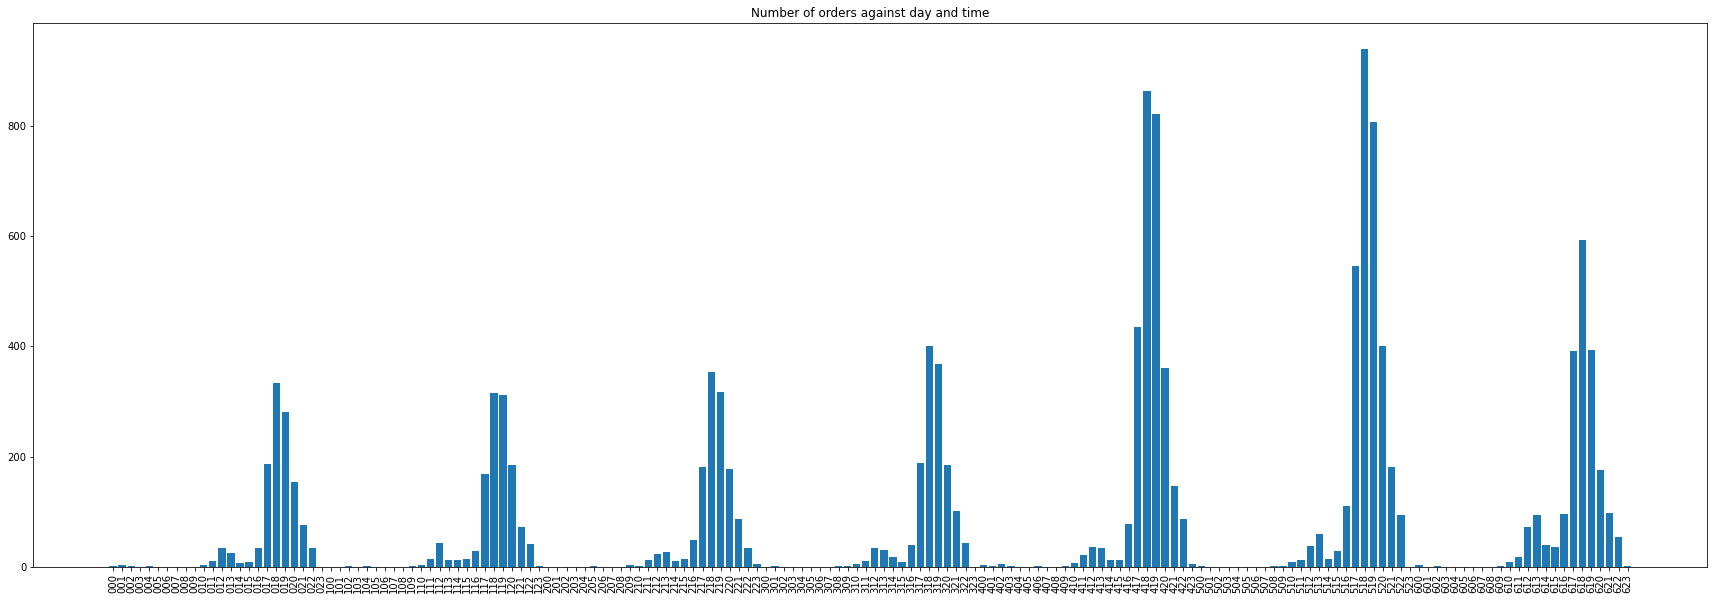

In [27]:
# Lets plot the order times
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
plt.title("Number of orders against day and time")
plt.bar(order_timings.keys(), order_timings.values())

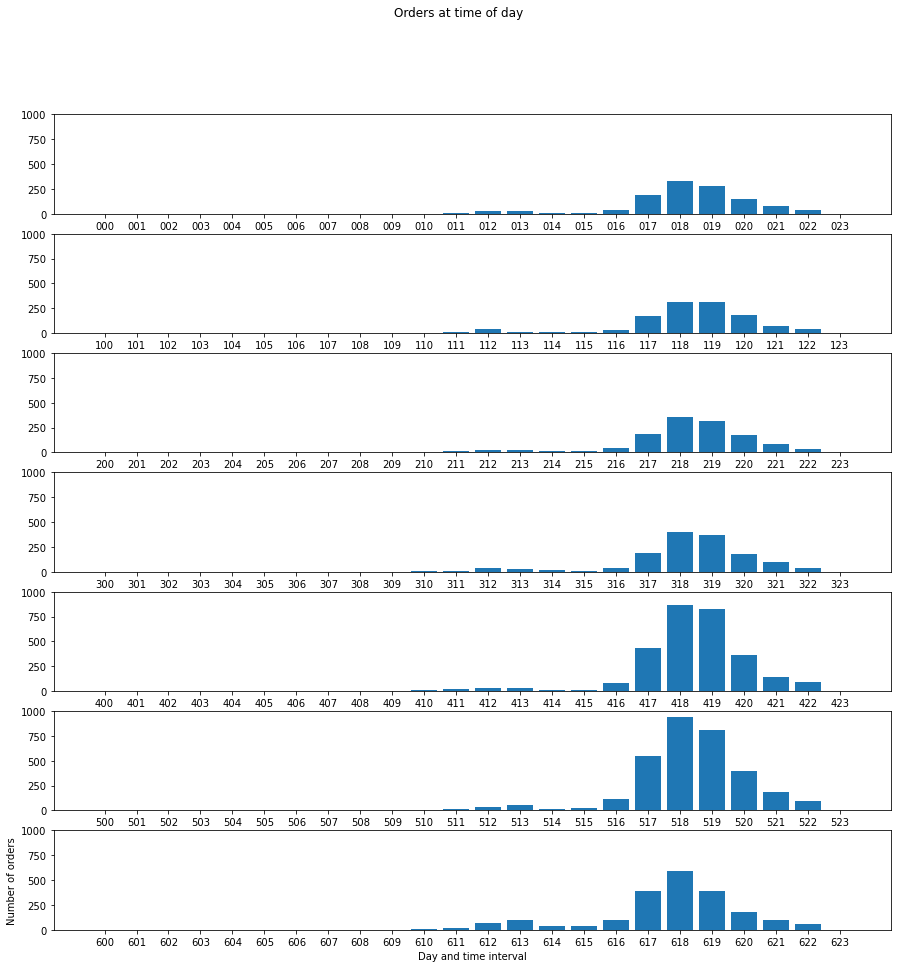

In [28]:
# Broken down into subplots for each day for easier viewing
fig, axs = plt.subplots(7,figsize=(15,15))
fig.suptitle('Orders at time of day')
plt.setp(axs, ylim=(0,1000))
plt.xlabel("Day and time interval")
plt.ylabel("Number of orders")
for num in range(7):
    axs[num].bar({k: v for k, v in order_timings.items() if k.startswith(str(num))}.keys(),
                 {k: v for k, v in order_timings.items() if k.startswith(str(num))}.values())

In [29]:
# We can similarly see how orders have increased over time, has the business been recieving more or less orders?
# Again, repeat the same process but this time the buckets will be Month/Year

order_days = {}
for order in unique_order_dates.itertuples():
    month_year = datetime.strftime(datetime.strptime(order[2], '%d/%m/%Y %H:%M').date(),'%m/%Y')
    if month_year in order_days:
        order_days[month_year] += 1
    else:
        order_days[month_year] = 1
order_days = {k:v for k,v in sorted(order_days.items(), key = lambda item:datetime.strptime(item[0], '%m/%Y'))}
order_days

{'09/2015': 17,
 '10/2015': 12,
 '03/2016': 112,
 '04/2016': 160,
 '05/2016': 179,
 '06/2016': 107,
 '07/2016': 82,
 '08/2016': 202,
 '09/2016': 207,
 '10/2016': 280,
 '11/2016': 261,
 '12/2016': 282,
 '01/2017': 278,
 '02/2017': 227,
 '03/2017': 256,
 '04/2017': 321,
 '05/2017': 276,
 '06/2017': 297,
 '07/2017': 342,
 '08/2017': 302,
 '09/2017': 330,
 '10/2017': 325,
 '11/2017': 318,
 '12/2017': 401,
 '01/2018': 327,
 '02/2018': 285,
 '03/2018': 349,
 '04/2018': 310,
 '05/2018': 318,
 '06/2018': 377,
 '07/2018': 390,
 '08/2018': 410,
 '09/2018': 444,
 '10/2018': 405,
 '11/2018': 451,
 '12/2018': 487,
 '01/2019': 406,
 '02/2019': 423,
 '03/2019': 514,
 '04/2019': 449,
 '05/2019': 534,
 '06/2019': 437,
 '07/2019': 460,
 '08/2019': 47}

<BarContainer object of 44 artists>

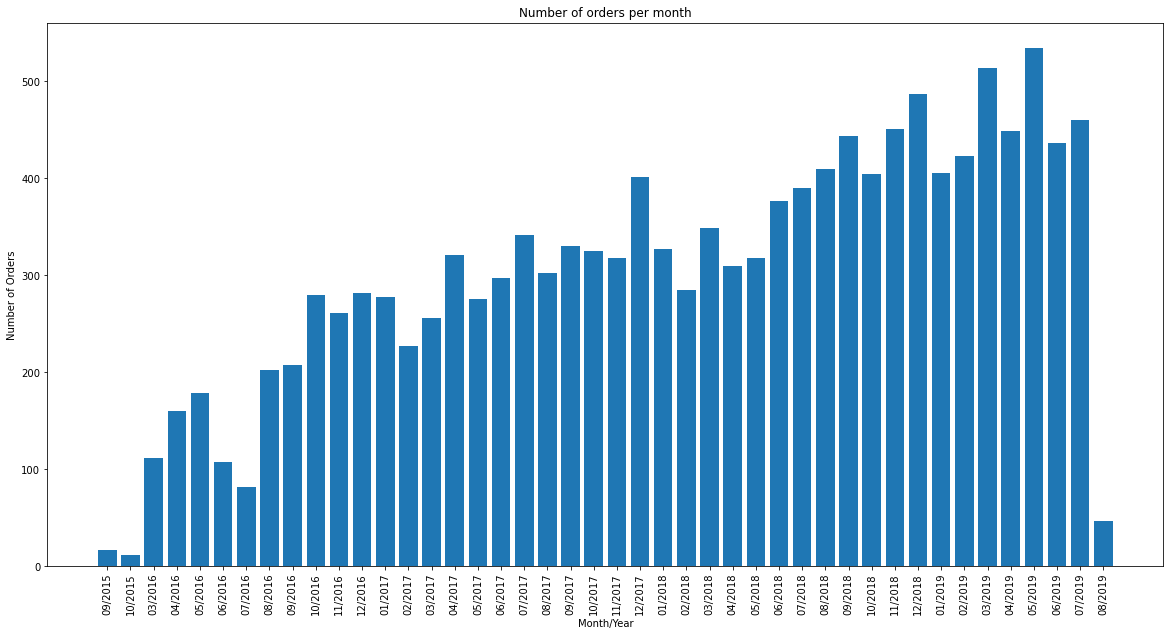

In [30]:
# Plot the number of orders per month
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xlabel("Month/Year")
plt.ylabel("Number of Orders")
plt.title("Number of orders per month")
plt.bar(order_days.keys(), order_days.values())

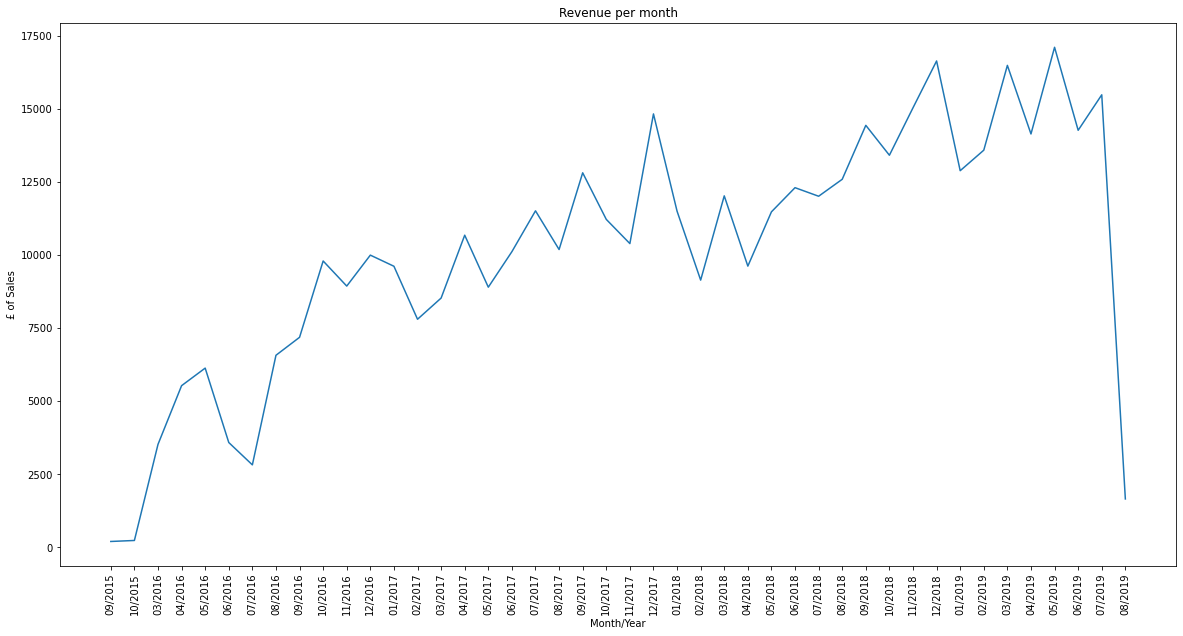

In [88]:
# Monthly spend
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xlabel("Month/Year")
plt.ylabel("£ of Sales")
plt.title("Revenue per month")
plt.plot(order_days.keys(), monthly_spend)

In [42]:
"""
I want to see what type of orders people are making? How many sides/mains are there per order? Are most orders for
a single person or multiple?

First we need to assign some categories to the products, we will use the price and some string manipulation
to determine the category - anything below £3 will count as a side, £3-4 will be a starter,
£4+ will count as a main and drinks will be determined by their name
"""
takeaway_1_prices = pd.read_csv("restaurant-1-products-price.csv")
takeaway_1_prices

,Item Name,Product Price
0,Mint Sauce,0.50
1,Lime Pickle,0.50
2,Mango Chutney,0.50
3,Red Sauce,0.50
4,Onion Chutney,0.50
...,...,...
243,King Prawn Karahi,12.95
244,Methi - King Prawn,12.95
245,Kurma,12.95
246,House Red wine 75cl,17.95


In [33]:
drinks_list = ['cobra','coke','lemonade','wine','water']
product_category = []
for row in takeaway_1_prices.itertuples():
    if any(ele in row[1].lower() for ele in drinks_list):
        product_category.append("Drink")
    elif row[2] < 3:
        product_category.append("Side")
    elif row[2] >= 3 and row[2] < 4:
        product_category.append("Starter")
    else:
        product_category.append("Main")
takeaway_1_prices['Category'] = product_category

In [34]:
def order_category(product_name, product_price):
    drinks_list = ['cobra','coke','lemonade','wine','water']
    if any(ele in product_name.lower() for ele in drinks_list):
        return "Drink"
    elif product_price < 3:
        return "Side"
    elif product_price >= 3 and product_price < 4:
        return "Starter"
    else:
        return "Main"

In [35]:
takeaway_1_prices

,Item Name,Product Price,Category
0,Mint Sauce,0.50,Side
1,Lime Pickle,0.50,Side
2,Mango Chutney,0.50,Side
3,Red Sauce,0.50,Side
4,Onion Chutney,0.50,Side
...,...,...,...
243,King Prawn Karahi,12.95,Main
244,Methi - King Prawn,12.95,Main
245,Kurma,12.95,Main
246,House Red wine 75cl,17.95,Drink


In [36]:
# Now we can loop through the original datatable and create a dictionary of types of order
order_habits = {}
for row in takeaway_1.itertuples():
    if row[1] not in order_habits:
        order_habits[row[1]] = {"Side":0,"Starter":0,"Main":0,"Drink":0}
    order_habits[row[1]][order_category(row[3],row[5])] += row[4]
order_habits

{16118: {'Side': 4, 'Starter': 1, 'Main': 2, 'Drink': 0},
 16117: {'Side': 2, 'Starter': 1, 'Main': 4, 'Drink': 0},
 16116: {'Side': 1, 'Starter': 0, 'Main': 4, 'Drink': 0},
 16115: {'Side': 5, 'Starter': 0, 'Main': 2, 'Drink': 0},
 16114: {'Side': 0, 'Starter': 2, 'Main': 1, 'Drink': 0},
 16113: {'Side': 3, 'Starter': 0, 'Main': 2, 'Drink': 0},
 16112: {'Side': 2, 'Starter': 1, 'Main': 2, 'Drink': 0},
 16111: {'Side': 2, 'Starter': 0, 'Main': 2, 'Drink': 0},
 16110: {'Side': 4, 'Starter': 0, 'Main': 5, 'Drink': 0},
 16109: {'Side': 7, 'Starter': 2, 'Main': 3, 'Drink': 0},
 16108: {'Side': 17, 'Starter': 3, 'Main': 5, 'Drink': 0},
 16107: {'Side': 2, 'Starter': 1, 'Main': 1, 'Drink': 0},
 16106: {'Side': 0, 'Starter': 1, 'Main': 2, 'Drink': 0},
 16105: {'Side': 6, 'Starter': 1, 'Main': 3, 'Drink': 0},
 16104: {'Side': 1, 'Starter': 1, 'Main': 2, 'Drink': 0},
 16103: {'Side': 0, 'Starter': 0, 'Main': 2, 'Drink': 0},
 16102: {'Side': 0, 'Starter': 2, 'Main': 2, 'Drink': 0},
 16101: {'Sid

In [93]:
# Now we need to think how we can accumulate the categories to a single order, we could have a dataframe with the
# following columns, Order Number (unique), Order Date, Side, Starter, Main and Drinks and populate each row

# Lets take a copy of the order date dataframe as a base
takeaway_1_order_habits = unique_order_dates

takeaway_1_order_habits = takeaway_1_order_habits.join(pd.DataFrame.from_dict(order_habits, orient='index').rename(index={0: "Order Number"})
                             ,on='Order Number')
takeaway_1_order_habits

,Order Number,Order Date,Side,Starter,Main,Drink
0,16118,03/08/2019 20:25,4,1,2,0
1,16117,03/08/2019 20:17,2,1,4,0
2,16116,03/08/2019 20:09,1,0,4,0
3,16115,03/08/2019 20:01,5,0,2,0
4,16114,03/08/2019 19:44,0,2,1,0
...,...,...,...,...,...,...
13392,4628,23/02/2017 18:20,0,0,1,0
13393,3504,23/10/2016 16:03,0,0,3,0
13394,12642,24/12/2018 13:22,0,0,0,2
13395,6567,31/08/2017 12:20,0,0,0,2


In [92]:
# Seems like on average, customers will order 3 sides, 1 starter and 3 mains with their orders. Drinks do not seem
# to be ordered much at all. Perhaps the restaurant can come up with some offers to entice more customers?
takeaway_1_order_habits.describe()

,Order Number,Side,Starter,Main,Drink
count,13397.000000,13397.000000,13397.000000,13397.000000,13397.000000
mean,9173.472643,3.223334,0.776069,2.857132,0.088378
std,4048.229127,3.248559,1.172754,2.078961,0.392084
min,630.000000,0.000000,0.000000,0.000000,0.000000
25%,5674.000000,1.000000,0.000000,2.000000,0.000000
50%,9231.000000,2.000000,0.000000,3.000000,0.000000
75%,12685.000000,4.000000,1.000000,4.000000,0.000000
max,16118.000000,90.000000,60.000000,130.000000,18.000000
